In [1]:
import os
import re
import time

import numpy as np
import cv2

from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class VehicleClassifier(object):
    
    def __init__(self):
        self.clf = clf = Pipeline([('scaling', StandardScaler()),
                ('classification', LinearSVC(loss='hinge')),
               ])
        self.hog = self.hog_descriptor()
    
    def _os_walk(self, _dir):
        matches = []
        
        img_re = re.compile(r'.+\.(jpg|png|jpeg|tif|tiff)$', re.IGNORECASE)
        
        for root, dirnames, filenames in os.walk(_dir):
            matches.extend(os.path.join(root, name) for name in filenames if img_re.match(name))
        
        return matches
    
    def load_non_vehicle_images(self):
        return self._os_walk("./non-vehicles")
        
        self.non_vehicle_labels  = [0] * len(non_vehicle_images)
    
    def load_vehicle_images(self):
        return self._os_walk("./vehicles")
    
    def bin_spatial_features(self, img, size):
        # Use cv2.resize().ravel() to create the feature vector
        return cv2.resize(img, size).ravel()
    
    def color_hist_features(self, img, nbins=16, bins_range=(0, 256)):
        
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
    

    def hog_descriptor(self, blockSize=(8, 8), blockStride=(8,8),
                            cellSize=(8,8), winSize=(64, 64), nbins=9,
                            derivAperture=1, winSigma=4., histogramNormType=0,
                            L2HysThreshold=2.0000000000000001e-01,
                            gammaCorrection=0, nlevels=64, winStride=(8,8),
                            padding=(8,8), locations=((10,20),)):
        
        return cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins,
                                    derivAperture, winSigma, histogramNormType,
                                    L2HysThreshold, gammaCorrection, nlevels)

    def extact_image_features(self, image, cspace='YUV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            
            else: feature_image = np.copy(image)      
                
        # Apply bin_spatial() to get spatial color features
        spatial_features = self.bin_spatial_features(feature_image, spatial_size)
            
        # Apply color_hist() also with a color space option now
        hist_features = self.color_hist_features(feature_image, nbins=hist_bins, bins_range=hist_range)

        # Apply hog_features() also to get shape related featuers
        hog_features = self.hog.compute(feature_image[:,:,0])[:,0]

        # Append the new feature vector to the features list
        return np.concatenate((spatial_features, hist_features, hog_features))
    
    def extract_features(self, images, cls, cspace='YUV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
        
        # Create a list to append feature vectors to
        features = []
        
        # Iterate through the list of images
        for img in images:
            # Read in each one by one
            image = cv2.imread(img)
            
            
            features.append(self.extact_image_features(image, cspace='YUV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)))

        # Return list of feature vectors and equal length labels
        return (features, [cls] * len(features))
    
    
    
    def load_data(self):
        def shuffle(x, y):
            perm = np.arange(len(x))
            np.random.shuffle(perm)
            x = x[perm]
            y = y[perm]

            return (x, y)
    
        print("loading vehicle images")

        vehicle_images = self.load_vehicle_images()
        
        print("load non-vehicle images")

        non_vehicle_images = self.load_non_vehicle_images()
        
        print("extract vehicle features")

        vehicle_features, y_vehicles = self.extract_features(vehicle_images, 1)
        
        print("extract non-vehicle features")

        n_vehicle_features, y_n_vehicles = self.extract_features(non_vehicle_images, 0)
        
        assert len(vehicle_features) == len(y_vehicles), 'vehicle features and labels are imbalanced'
        
        assert len(n_vehicle_features) == len(y_n_vehicles), 'non vehicle features and labels are imbalanced'
        
        count = min(len(vehicle_features), len(n_vehicle_features))
        
        vehicle_features = vehicle_features[:count]
        
        n_vehicle_features = n_vehicle_features[:count]

        y_vehicles = y_vehicles[:count]

        y_n_vehicles = y_n_vehicles[:count]
        
        x = np.vstack((vehicle_features, n_vehicle_features)).astype(np.float64)
        
        x = x.reshape((x.shape[0], -1), order='F')
        
        y = np.hstack((y_vehicles, y_n_vehicles))

        print("train / test split")
        
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
        
        return (X_train, X_test, y_train, y_test)
    
    def calc_accuracy(self, y_true, y_pred):
        return accuracy_score(y_true, y_pred)

def main():
    vc = VehicleClassifier()
    
    X_train, X_test, y_train, y_test = vc.load_data()
    
    # assert len(X) == len(Y), 'imbalanced data'
    
    print("train model")

    t = time.time()

    vc.clf.fit(X_train, y_train)
    
    t2 = time.time()

    print(round(t2-t, 2), 'Seconds to train SVC...')
    
    print("testing model")

    # y_pred = vc.clf.predict(X_test)
    
    print('Test Accuracy of classifier = ', round(vc.clf.score(X_test, y_test), 4))

    return vc

In [2]:
def main():
    vc = VehicleClassifier()
    
    X_train, X_test, y_train, y_test = vc.load_data()
    
    # assert len(X) == len(Y), 'imbalanced data'
    
    print("train model")

    t = time.time()

    vc.clf.fit(X_train, y_train)
    
    t2 = time.time()

    print(round(t2-t, 2), 'Seconds to train SVC...')
    
    print("testing model")

    # y_pred = vc.clf.predict(X_test)
    
    print('Test Accuracy of classifier = ', round(vc.clf.score(X_test, y_test), 4))

    return vc

In [3]:
vc = main()

loading vehicle images
load non-vehicle images
extract vehicle features
extract non-vehicle features
train / test split
train model
8.75 Seconds to train SVC...
testing model
Test Accuracy of classifier =  0.9797


In [4]:

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, vc):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = vc.extact_image_features(test_img, cspace='YUV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
        #5) Scale extracted features to be fed to classifier
#         test_features = scaler.transform(np.array(features).reshape(1, -1))
        features = features.astype(np.float64)
        #6) Predict using your classifier
        prediction = vc.clf.predict(features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
y_start_stop = [350, 720] # Min and max in y to search in slide_window()

image = cv2.imread('test_images/test1.jpg')

draw_image = np.copy(image)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, vc)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single

In [7]:
print(hot_windows)

[((832, 414), (896, 478)), ((864, 414), (928, 478)), ((1088, 414), (1152, 478)), ((1152, 414), (1216, 478)), ((1184, 414), (1248, 478)), ((1056, 446), (1120, 510)), ((1088, 446), (1152, 510)), ((1120, 446), (1184, 510)), ((1152, 446), (1216, 510)), ((1184, 446), (1248, 510)), ((1216, 446), (1280, 510)), ((0, 542), (64, 606))]


In [8]:
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  

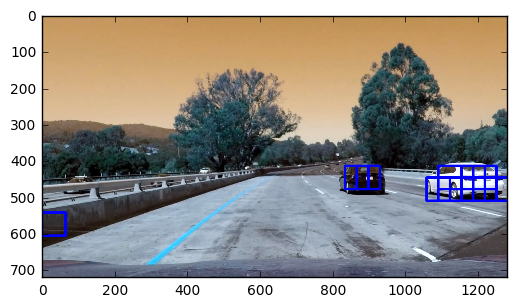

In [9]:
plt.imshow(window_img)

In [33]:
def update_heatmap(candidates, image_shape, heatmap=None):
    if heatmap is None:
        heatmap = np.zeros((image_shape[0], image_shape[1]), np.uint8)

    for pt1, pt2 in candidates:
        x1, y1 = pt1
        x2, y2 = pt2
        x1 = min(max(x1, 0), image_shape[1])
        x2 = min(max(x2, 0), image_shape[1])
        y1 = min(max(y1, 0), image_shape[0])
        y2 = min(max(y2, 0), image_shape[0])
        xv, yv = np.meshgrid(range(x1, x2), range(y1, y2))

        heatmap[yv, xv] += 1

    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [34]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [35]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = update_heatmap(hot_windows, image.shape)
heatmap = apply_threshold(heatmap, 2)

In [36]:
from scipy.ndimage.measurements import label
labels = label(heatmap)
print(labels)

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)


In [37]:
def centroid(box, as_int=False):
    """
    Computes the centroid of a bounding box
    """
    x1, y1 = box[0]
    x2, y2 = box[1]
    print((int((x1+x2)//2), ((y1+y2)//2)))
    return (int((x1+x2)//2), ((y1+y2)//2))

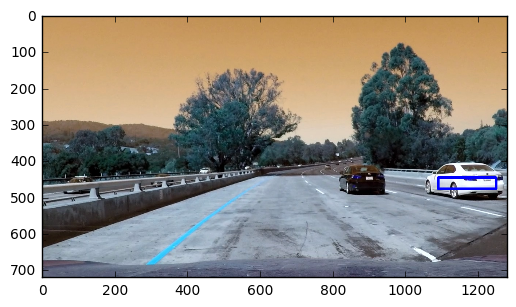

In [38]:
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.imshow(draw_img)